🚀 Bắt đầu phân tích sự kiện: Ảnh hưởng của khủng hoảng Credit Suisse đến VN-Index
🌍 Sử dụng MSCI World từ file CSV
✅ Đã đọc xong VN-Index: 1403 ngày
✅ Đã đọc xong CDS Credit Suisse: 3525 ngày
✅ Đã đọc xong MSCI World: 1468 ngày
📊 Dữ liệu sau khi gộp (inner join): 884 ngày

🔍 Kiểm tra kiểu dữ liệu:
date           datetime64[ns]
vn_index              float64
cs_cds                float64
world_index           float64
dtype: object
✅ Đã tính lợi suất log-return

🎯 Ngày sự kiện: 2023-03-19
⚠️  Không có dữ liệu vào 2023-03-14 → dùng ngày gần nhất: 2023-03-20
🎯 Ngày sự kiện được xác định: 2023-03-15 (biến động CDS lớn nhất: 842.62)

📈 Mô hình CAPM: r_vn = -0.001494 + -0.0100 × r_mkt
R² = 0.000, p-value (beta) = 0.8987

📊 Kết quả Abnormal Return (AR) và CAR trong cửa sổ [-5, +5]:
          date      r_vn     r_mkt  expected        AR       CAR
695 2022-10-18 -0.009719  0.024143 -0.001735 -0.007984 -0.007984
696 2022-10-19  0.011422  0.010944 -0.001603  0.013025  0.005041
697 2022-10-20 -0.007

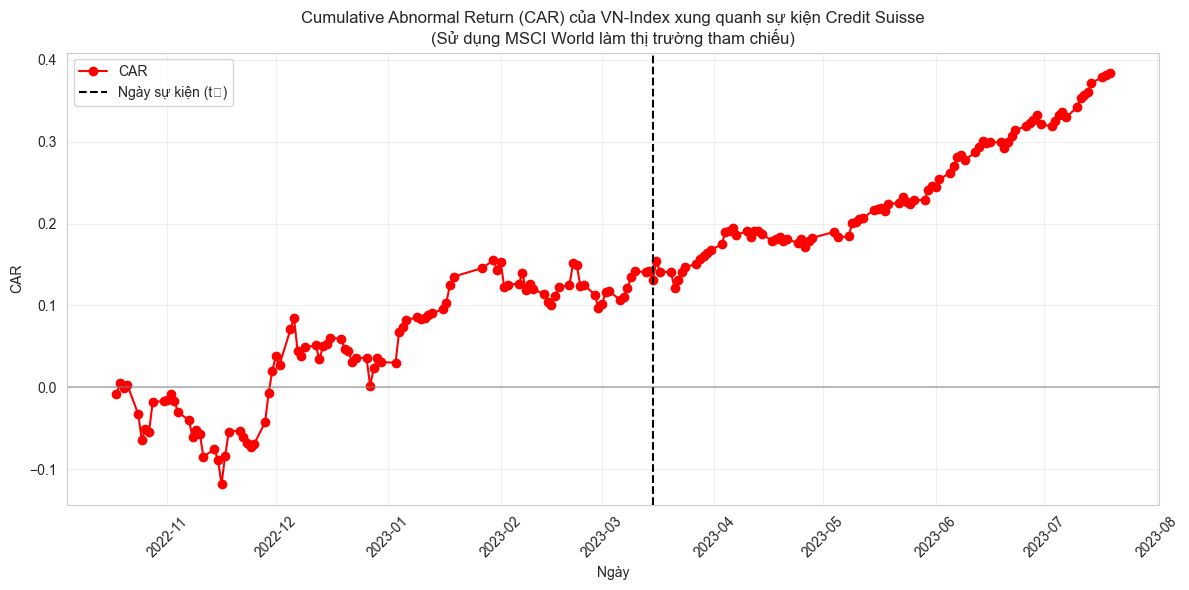


✅ Phân tích hoàn tất. Biểu đồ đã được lưu: car_vn_index_msci.png


In [24]:
# %% 1. Import thư viện
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

print("🚀 Bắt đầu phân tích sự kiện: Ảnh hưởng của khủng hoảng Credit Suisse đến VN-Index")
print("🌍 Sử dụng MSCI World từ file CSV")

# ----------------- Hàm hỗ trợ: Chuyển chuỗi thành số -----------------
def to_numeric_safe(s):
    """
    Chuyển chuỗi thành số, xử lý dấu phẩy, khoảng trắng
    """
    if pd.isna(s) or s == '':
        return np.nan
    # Thay dấu phẩy bằng dấu chấm, loại bỏ ký tự không cần thiết
    s = str(s).strip().replace(',', '').replace(' ', '')
    try:
        return float(s)
    except ValueError:
        return np.nan

# ----------------- 1. VN-Index -----------------
try:
    vn = pd.read_csv(r"C:\Users\user\Downloads\Dữ liệu Lịch sử VN Index (1).csv", encoding="utf-8")
    vn = vn.rename(columns={"Ngày": "date", "Mở": "vn_index"})
    vn["date"] = pd.to_datetime(vn["date"])
    vn["vn_index"] = vn["vn_index"].apply(to_numeric_safe)
    vn = vn.sort_values("date").drop_duplicates(subset="date")
    vn = vn.bfill().ffill()   # bù trước và sau
    vn = vn[["date", "vn_index"]]
    print(f"✅ Đã đọc xong VN-Index: {len(vn)} ngày")
except Exception as e:
    raise RuntimeError(f"Lỗi khi đọc VN-Index: {e}")

# ----------------- 2. CDS Credit Suisse -----------------
try:
    cds = pd.read_csv(r"C:\Users\user\Downloads\CSGN5YEUAM=R Overview (2).csv", encoding="utf-8")
    cds = cds.rename(columns={"Date": "date", "Open": "cs_cds"})
    cds["date"] = pd.to_datetime(cds["date"])
    cds["cs_cds"] = cds["cs_cds"].apply(to_numeric_safe)
    cds = cds.sort_values("date").drop_duplicates(subset="date")
    cds = cds.bfill().ffill()
    cds = cds[["date", "cs_cds"]]
    print(f"✅ Đã đọc xong CDS Credit Suisse: {len(cds)} ngày")
except Exception as e:
    raise RuntimeError(f"Lỗi khi đọc CDS: {e}")

# ----------------- 3. MSCI World -----------------
try:
    msci = pd.read_csv(r"C:\Users\user\Downloads\MSCI World Historical Data (1).csv", encoding="utf-8")
    msci = msci.rename(columns={"Date": "date", "Open": "world_index"})
    msci["date"] = pd.to_datetime(msci["date"])
    msci["world_index"] = msci["world_index"].apply(to_numeric_safe)
    msci = msci.sort_values("date").drop_duplicates(subset="date")
    msci = msci.bfill().ffill()
    msci = msci[["date", "world_index"]]
    print(f"✅ Đã đọc xong MSCI World: {len(msci)} ngày")
except Exception as e:
    raise RuntimeError(f"Lỗi khi đọc MSCI World: {e}")

# ----------------- 4. Merge dữ liệu -----------------
df = vn.merge(cds, on="date", how="inner").merge(msci, on="date", how="inner")
print(f"📊 Dữ liệu sau khi gộp (inner join): {len(df)} ngày")

if len(df) < 10:
    raise ValueError("Không đủ dữ liệu sau khi gộp. Kiểm tra khoảng ngày.")

# ----------------- 5. Kiểm tra kiểu dữ liệu trước khi tính toán -----------------
print("\n🔍 Kiểm tra kiểu dữ liệu:")
print(df.dtypes)

# Ép kiểu an toàn
for col in ["vn_index", "world_index", "cs_cds"]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna().reset_index(drop=True)

# ----------------- 6. Tính lợi suất log-return -----------------
df["r_vn"] = np.log(df["vn_index"] / df["vn_index"].shift(1))
df["r_mkt"] = np.log(df["world_index"] / df["world_index"].shift(1))
df["d_cds"] = df["cs_cds"].diff()
df = df.dropna().reset_index(drop=True)

print("✅ Đã tính lợi suất log-return")

# ----------------- 7. Xác định ngày sự kiện -----------------
event_date = pd.to_datetime("2023-03-19")
print(f"\n🎯 Ngày sự kiện: {event_date.date()}")

if event_date not in df["date"].values:
    available_dates = df["date"][df["date"] >= event_date]
    if len(available_dates) == 0:
        raise ValueError(f"Không tìm thấy ngày sự kiện hoặc ngày sau đó trong dữ liệu")
    event_date = available_dates.iloc[0]
    print(f"⚠️  Không có dữ liệu vào 2023-03-14 → dùng ngày gần nhất: {event_date.date()}")

# ----------------- Xác định ngày sự kiện theo biến động CDS -----------------
max_jump_idx = df["d_cds"].abs().idxmax()   # chỉ số ngày biến động CDS lớn nhất
event_date = df.loc[max_jump_idx, "date"]

print(f"🎯 Ngày sự kiện được xác định: {event_date.date()} (biến động CDS lớn nhất: {df.loc[max_jump_idx, 'd_cds']:.2f})")

t0 = max_jump_idx

# ----------------- 8. Estimation Window: [-250, -20] -----------------
est_start = t0 - 250
est_end = t0 - 20

if est_start < 0:
    raise ValueError("Không đủ dữ liệu trước sự kiện để ước lượng mô hình")

est = df.iloc[est_start:est_end + 1]
X = sm.add_constant(est["r_mkt"])
y = est["r_vn"]
model = sm.OLS(y, X).fit()
alpha, beta = model.params

print(f"\n📈 Mô hình CAPM: r_vn = {alpha:.6f} + {beta:.4f} × r_mkt")
print(f"R² = {model.rsquared:.3f}, p-value (beta) = {model.pvalues['r_mkt']:.4f}")

# ----------------- 9. Event Window: [-5, +5] -----------------
event_start = max(t0 - 100, 0)
event_end = min(t0 + 100, len(df) - 1)

win = df.iloc[event_start:event_end + 1].copy()
win["expected"] = alpha + beta * win["r_mkt"]
win["AR"] = win["r_vn"] - win["expected"]
win["CAR"] = win["AR"].cumsum()

# ----------------- 10. In kết quả -----------------
print(f"\n📊 Kết quả Abnormal Return (AR) và CAR trong cửa sổ [-5, +5]:")
print(win[["date", "r_vn", "r_mkt", "expected", "AR", "CAR"]].round(6))

# ----------------- 11. Kiểm định CAR -----------------
CAR = win["AR"].sum()
resid_std = model.resid.std(ddof=1)
T = len(win)
se_car = resid_std * np.sqrt(T)
t_stat = CAR / se_car
p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df=len(est) - 2))

print(f"\n✅ KẾT LUẬN KIỂM ĐỊNH")
print(f"CAR[-5, +5] = {CAR:.4%}")
print(f"Standard Error of CAR = {se_car:.6f}")
print(f"t-statistic = {t_stat:.3f}")
print(f"p-value = {p_val:.4f}")
print(f"→ {'✅ Có tác động ý nghĩa' if p_val < 0.05 else '❌ Không có tác động ý nghĩa'} đến VN-Index")

# ----------------- 12. Trực quan hóa CAR -----------------
plt.figure(figsize=(12, 6))
plt.plot(win["date"], win["CAR"], marker='o', color='red', label='CAR')
plt.axvline(x=df.loc[t0, "date"], color='black', linestyle='--', label='Ngày sự kiện (t₀)')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
plt.title('Cumulative Abnormal Return (CAR) của VN-Index xung quanh sự kiện Credit Suisse\n(Sử dụng MSCI World làm thị trường tham chiếu)')
plt.ylabel('CAR')
plt.xlabel('Ngày')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("car_vn_index_msci.png", dpi=300)
plt.show()

print("\n✅ Phân tích hoàn tất. Biểu đồ đã được lưu: car_vn_index_msci.png")

In [25]:
# %% 8. Kiểm định Granger Causality giữa VN-Index và CDS Credit Suisse
from statsmodels.tsa.stattools import grangercausalitytests

# Chọn dữ liệu chỉ gồm VN-Index và CDS
gc_data = df[["r_vn", "d_cds"]].copy()

# Lựa chọn số lags tối đa để kiểm định (ví dụ 5 ngày)
max_lag = 5

print(f"\n🔍 Kiểm định Granger Causality 2 chiều giữa VN-Index và CDS (max_lag={max_lag}):\n")

# Granger test: d_cds gây r_vn
print("1️⃣ Kiểm tra CDS -> VN-Index")
grangercausalitytests(gc_data[["r_vn", "d_cds"]], maxlag=max_lag, verbose=True)

# Granger test: r_vn gây d_cds
print("\n2️⃣ Kiểm tra VN-Index -> CDS")
grangercausalitytests(gc_data[["d_cds", "r_vn"]], maxlag=max_lag, verbose=True)



🔍 Kiểm định Granger Causality 2 chiều giữa VN-Index và CDS (max_lag=5):

1️⃣ Kiểm tra CDS -> VN-Index

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9704  , p=0.0466  , df_denom=879, df_num=1
ssr based chi2 test:   chi2=3.9840  , p=0.0459  , df=1
likelihood ratio test: chi2=3.9750  , p=0.0462  , df=1
parameter F test:         F=3.9704  , p=0.0466  , df_denom=879, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5687  , p=0.0772  , df_denom=876, df_num=2
ssr based chi2 test:   chi2=5.1666  , p=0.0755  , df=2
likelihood ratio test: chi2=5.1516  , p=0.0761  , df=2
parameter F test:         F=2.5687  , p=0.0772  , df_denom=876, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9284  , p=0.1234  , df_denom=873, df_num=3
ssr based chi2 test:   chi2=5.8315  , p=0.1201  , df=3
likelihood ratio test: chi2=5.8123  , p=0.1211  , df=3
parameter F test:         F=1.9284  , p=0.1234  , df_denom=873, 

{1: ({'ssr_ftest': (0.6557389163216675, 0.4182874640255826, 879.0, 1),
   'ssr_chi2test': (0.6579769331009223, 0.4172750717640177, 1),
   'lrtest': (0.6577316278562648, 0.4173619079635704, 1),
   'params_ftest': (0.6557389163218863, 0.4182874640255133, 879.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.8902717268314752, 0.4109152973001078, 876.0, 2),
   'ssr_chi2test': (1.7907063729190174, 0.4084633094517499, 2),
   'lrtest': (1.7888889547775761, 0.40883465246193307, 2),
   'params_ftest': (0.8902717268313712, 0.4109152973001675, 876.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.13487990743852382, 0.9392538052359368, 873.0, 3),
   'ssr_chi2test': (0.40788425617148094, 0.9386090193812374, 3),
   'lrtest': (0.4077897572078655, 0.9386286538766835, 3),
   'params_ftest': (0.1348799074385322, 0.9392538052359368, 873.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0